In [150]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tqdm
import sys
import time
import datetime
import scipy.stats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.calibration import calibration_curve

from Py_Files import metric_inventory
from Py_Files import aws_rds
from Py_Files import credentials
from Py_Files import data_exploration
from Py_Files import analytics


print(sys.executable)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/joeybortfeld/opt/anaconda3/envs/investment_analysis/bin/python


In [170]:
data = pd.read_csv('/Users/joeybortfeld/Downloads/modeling_dataset_with_bankruptcy_labels.csv')
data['fiscal_end_date'] = pd.to_datetime(data['fiscal_end_date'])
data['constant'] = 1
print(data.shape)
print(data['fsym_id'].nunique())
print(data['fiscal_end_date'].min())
print(data['fiscal_end_date'].max())

print(data['default_1'].value_counts())

# build broad sector mapping
factset_econ_sector_to_broad_dict = {   
'Commercial Services': 'Consumer',
'Communications': 'Consumer',
'Consumer Durables': 'Consumer',
'Consumer Non-Durables': 'Consumer',
'Consumer Services': 'Consumer',
'Distribution Services': 'Consumer',
'Electronic Technology': 'Technology',
'Energy Minerals': 'Industrial',
'Finance': 'Consumer',
'Health Services': 'Healthcare',
'Health Technology': 'Healthcare',
'Industrial Services': 'Industrial',
'Miscellaneous': 'Consumer',
'Non-Energy Minerals': 'Industrial',
'Process Industries': 'Industrial',
'Producer Manufacturing': 'Industrial',
'Retail Trade': 'Consumer',
'Technology Services': 'Technology',
'Transportation': 'Industrial',
'Utilities': 'Utilities',
'@NA': 'Consumer'
}

data['factset_econ_sector_broad'] = data['factset_econ_sector'].map(factset_econ_sector_to_broad_dict)



# build interaction terms
data['ff_assets_in_usd'] = data.groupby('fsym_id')['ff_assets_in_usd'].ffill(limit=4)

# convert to decile
data['ff_assets_in_usd_decile'] = pd.qcut( data['ff_assets_in_usd'], q=100, labels=False)
data['total_equity_to_assets_decile'] = pd.qcut(data['total_equity_to_assets'], q=100, labels=False)
data['net_income_to_sales_decile'] = pd.qcut(data['net_income_to_sales'], q=100, labels=False)

for m in ['ff_assets_in_usd_decile', 'total_equity_to_assets_decile', 'net_income_to_sales_decile']:
    data[m] = data[m] + 1

data['size_x_leverage'] = data['ff_assets_in_usd_decile'] * data['total_equity_to_assets_decile']
data['size_x_profitability'] = data['ff_assets_in_usd_decile'] * data['net_income_to_sales_decile']

data['size_x_leverage'] = pd.qcut(data['size_x_leverage'], q=100, labels=False)
data['size_x_profitability'] = pd.qcut(data['size_x_profitability'], q=100, labels=False)

print('done all')

/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/696160429.py:1: DtypeWarning: Columns (159) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/joeybortfeld/Downloads/modeling_dataset_with_bankruptcy_labels.csv')


(902682, 167)
15396
1990-01-31 00:00:00
2024-12-31 00:00:00
default_1
 0    894593
-1      6201
 1      1888
Name: count, dtype: int64
done all


In [220]:
model_list = [

# {'model_number': 0, 'model_name': 'baseline model',
#  'x1_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
#  'x2_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
#  'x3_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
#  'x4_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
#  'x5_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
#  'incl_sector_dummies': False,
#  'sector_dummies_var': 'factset_econ_sector',
#  'sector_var': 'factset_econ_sector', # used for intra-sector AUROC calculations, cross-sector rank correlation
#  'test_split_date_list': None,
# 'write_company_outputs': False

#  },

#  {'model_number': 1, 'model_name': 'sector dummies + variable ratios',
#  'x1_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x2_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x3_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x4_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x5_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'incl_sector_dummies': True,
#  'sector_dummies_var': 'factset_econ_sector_broad',
#  'sector_var': 'factset_econ_sector_broad', # used for intra-sector AUROC calculations, cross-sector rank correlation
#  'test_split_date_list': None,
#  'write_company_outputs': False
#  },


#  {'model_number': 2, 'model_name': 'sector dummies + variable ratios + test',
#  'x1_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x2_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x3_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x4_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x5_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'incl_sector_dummies': True,
#  'sector_dummies_var': 'factset_econ_sector_broad',
#  'sector_var': 'factset_econ_sector_broad', # used for intra-sector AUROC calculations, cross-sector rank correlation
#  'test_split_date_list': ['2020-01-01', '2019-01-01', '2018-01-01', '2017-01-01', '2016-01-01'],
#   'write_company_outputs': False
#  },

#   {'model_number': 3, 'model_name': 'size',
#  'x1_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x2_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x3_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x4_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'x5_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
#  'incl_sector_dummies': True,
#  'sector_dummies_var': 'factset_econ_sector_broad',
#  'sector_var': 'factset_econ_sector_broad', # used for intra-sector AUROC calculations, cross-sector rank correlation
#  'test_split_date_list': None,
#   'write_company_outputs': False
#  },

  {'model_number': 4, 'model_name': 'no volatility',
 'x1_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x2_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x3_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_interest_expense', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x4_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x5_specs': [('ff_assets_in_usd', 'pct'), ('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'incl_sector_dummies': True,
 'sector_dummies_var': 'factset_econ_sector_broad',
 'sector_var': 'factset_econ_sector_broad', # used for intra-sector AUROC calculations, cross-sector rank correlation
 'test_split_date_list': None,
  'write_company_outputs': True
 },


]

In [222]:
verbose = True
write_results = True
write_dir = '/Users/joeybortfeld/Documents/QML Solutions Data/exploratory_data/default_model_regressions/'
write_company_outputs_dir = '/Users/joeybortfeld/Documents/QML Solutions Data/exploratory_data/default_model_company_outputs/'

models_meta = []
for this_model in model_list:

    # extract model specifications
    model_num = this_model['model_number']
    model_name = this_model['model_name']

    print(model_num, model_name)

    incl_sector_dummies = this_model['incl_sector_dummies']
    sector_dummies_var = this_model['sector_dummies_var']
    sector_var = this_model['sector_var']
    test_split_date_list = this_model['test_split_date_list']
    write_company_outputs = this_model['write_company_outputs']

    x_dict = {}
    x_dict['specs'] = {}
    x_dict['specs'][1] = this_model['x1_specs']
    x_dict['specs'][2] = this_model['x2_specs']
    x_dict['specs'][3] = this_model['x3_specs']
    x_dict['specs'][4] = this_model['x4_specs']
    x_dict['specs'][5] = this_model['x5_specs']

    x_dict['base_vars'] = {}
    x_dict['vars'] = {}
    x_dict['vars_to_pct'] = {}
    for i in [1,2,3,4,5]:
        x_dict['base_vars'][i] = [x[0] for x in x_dict['specs'][i]]
        x_dict['vars'][i] = [x[0] if x[1] == 'level' else f'{x[0]}_pct' for x in x_dict['specs'][i]]
        x_dict['vars_to_pct'][i] = [x[0] for x in x_dict['specs'][i] if x[1] == 'pct']


    # generate a list of all base variables across all horizons
    all_base_vars_list = []
    for i in [1,2,3,4,5]:
        all_base_vars_list.extend(x_dict['base_vars'][i])
    all_base_vars_list = list(set(all_base_vars_list))

    all_x_vars_list = []
    for i in [1,2,3,4,5]:
        all_x_vars_list.extend(x_dict['vars'][i])
    all_x_vars_list = list(set(all_x_vars_list))

    all_x_to_pct_list = []
    for i in [1,2,3,4,5]:
        all_x_to_pct_list.extend(x_dict['vars_to_pct'][i])
    all_x_to_pct_list = list(set(all_x_to_pct_list))

    if verbose:
        print('x_vars:', all_x_vars_list)
        print('all base vars:', all_base_vars_list)
        print('vars to apply percentiles to:', all_x_to_pct_list)
    
    ########################################################
    # build training dataset (and test dataset if applicable)
    df_model = data[['fsym_id', 'fiscal_end_date', 'factset_econ_sector', 'factset_econ_sector_broad', 'ff_assets_in_usd_decile', 'bankruptcy_date',] + all_base_vars_list + ['default_1', 'default_2', 'default_3', 'default_4', 'default_5']].copy()

    if incl_sector_dummies:
        
        # construct sector dummies
        sector_dummies = pd.get_dummies(df_model[sector_dummies_var], prefix='sector', dtype=float, drop_first=True)
        df_model = pd.concat([df_model, sector_dummies], axis=1)
        print('--including sector dummies:', sector_dummies.columns)
        print('--sector holdout:', [x for x in df_model[sector_dummies_var].unique() if not f'sector_{x}' in sector_dummies.columns])


    # percentile calculation and transformations
    # -- if using test data,use the 1Y train/test split date to split off a dataset for percentile calculations
    # -- otherwise, use the full dataset
    df_pct_set = df_model.copy()
    mask = df_pct_set[all_base_vars_list].isna().any(axis=1)
    df_pct_set = df_pct_set[~mask]
    if test_split_date_list is not None:
        df_pct_set = df_pct_set[df_pct_set['fiscal_end_date'] < pd.to_datetime(test_split_date_list[0])].copy()

    # apply percentile transfomations to x-variables
    cutpoints_dict = {}
    if len(all_x_to_pct_list) > 0:
        
        for x in all_x_to_pct_list:
            if verbose:
                print(f'--calculating cutpoints for {x}')
            this_boundaries = analytics.calculate_percentile_bins(df_pct_set, column=x, num_bins=1000)
            cutpoints_dict[x] = this_boundaries

            df_model[f'{x}_pct'] = analytics.assign_to_bins(df_model, column=x, boundaries=this_boundaries)

    # calculate variable correlations
    df_correlation = analytics.calculate_variable_correlations(df_model, all_x_vars_list)
    if write_results:
        df_correlation.to_csv(write_dir + f'model_variable_correlations_{model_num}.csv', index=False)


    ########################################################
    # iterate over default horizons
    all_stats = []
    intra_sector_auroc = []
    sector_means =[]
    cross_sector_rank_corr = []
    coeff_dict = {}

    for t, y_var in enumerate(['default_1', 'default_2', 'default_3', 'default_4', 'default_5']):

        print('--regression on', y_var)

        this_test_split_date = test_split_date_list[t] if test_split_date_list is not None else None

        # build the train / test dataset
        df_train = df_model.copy()
        if test_split_date_list is not None:
            df_test = df_model[df_model['fiscal_end_date'] > pd.to_datetime(this_test_split_date)].copy()
            df_train = df_model[df_model['fiscal_end_date'] <= pd.to_datetime(this_test_split_date)].copy()

        # drop rows with incomplete x-variables from train data
        mask = df_train[all_base_vars_list].isna().any(axis=1)
        df_train = df_train[~mask]

        # get the x-variables for the current horizon
        x_vars = x_dict['vars'][int(y_var[-1])]
        x_vars_ratios_only = x_vars.copy()
        if incl_sector_dummies:
            x_vars.extend(sector_dummies.columns.tolist())

        coeff_dict[y_var] = {}

        # subset the training data to ignore default=-1 during the model regression
        dff = df_train[df_train[y_var] != -1].copy()

        # estimation dataset statistics
        nobs = dff.shape[0]
        n_fsym_id = dff['fsym_id'].nunique()
        n_default = dff[y_var].sum()
        n_fsym_id_default = dff[dff[y_var]==1]['fsym_id'].nunique()
        
        # regression
        X = dff[x_vars]
        y = dff[y_var].values
        logit_model = sm.Logit(y, X, maxiter=100)
        result = logit_model.fit()
        
        # collect estimated regression parameters and performance
        coefs = result.params
        tstats = result.tvalues
        pvals = result.pvalues

        # calculate AUROC using the estimation dataset
        y_pred = result.predict(X)
        dff['y_pred'] = y_pred
        auroc = roc_auc_score(np.array(y), np.array(y_pred))
        
        # save in-sample (estimation) statistics as table
        stats = pd.DataFrame({'x': x_vars, 'coef': coefs, 'tstat': tstats, 'pval': pvals})
        stats['auroc'] = auroc
        stats['y'] = y_var
        stats['nobs'] = nobs
        stats['n_fsym_id'] = n_fsym_id
        stats['n_default'] = n_default
        stats['n_fsym_default'] = n_fsym_id_default
        stats['mean_y'] = y.mean()

        # order variables by type
        stats['base_var'] = stats['x']
        stats['base_var'] = stats['base_var'].map(lambda x: x.replace('_pct', ''))
        
        stats['var_type'] = np.NaN
        mask1 = stats['base_var'].str.contains('sector_')
        mask2 = stats['base_var'].str.contains('constant')
        stats.loc[mask1 | mask2, 'var_type'] = 'dummy'

        mask3 = stats['var_type'].isna()
        stats.loc[mask3, 'var_type'] = stats.loc[mask3, 'base_var'].map(lambda x: metric_inventory.display_name_dict[x]['category'])

        order_dict = {'size':0, 'leverage': 1, 'coverage': 2, 'profitability': 3, 'liquidity': 4, 'volatility': 5, 'interaction': 6, 'dummy': 7}
        stats['var_type_order'] = stats['var_type'].map(lambda x: order_dict[x])
        stats = stats.sort_values(by=['var_type_order', 'x'])
        
        # calculate pseudo-weights
        X_stds = X.std()
        stats['x_sd'] = stats['x'].map(lambda x: X_stds[x])
        stats['weight'] = abs(stats['coef']) * stats['x_sd']
        total_non_sector_weight = stats[~stats['x'].str.contains('sector_')]['weight'].sum()
        stats['weight'] = stats['weight'] / total_non_sector_weight

        mask = stats['x'].str.contains('sector_')
        stats.loc[mask, 'weight'] = np.NaN

        all_stats.append(stats)

        # collect regression coefficients for later calculations (out-of-estimation dataset) and save into dictionary
        for i, var in enumerate(x_vars):
            coeff_dict[y_var][var] = coefs[i]

        # calculate in-sample intra-sector auroc
        sector_list = ['All'] + list(dff[sector_var].unique()) 
        sector_auroc_list = []
        for this_sector in sector_list:

            if this_sector == 'All':
                dff_sector = dff.copy()
            else:
                dff_sector = dff[dff[sector_var] == this_sector].copy()

            if dff_sector[y_var].sum() > 0:
                auroc = roc_auc_score(dff_sector[y_var], dff_sector['y_pred'])
                sector_auroc_list.append([this_sector, auroc])
        
        sector_auroc = pd.DataFrame(sector_auroc_list, columns=['sector', 'auroc'])
        sector_auroc = sector_auroc.rename(columns={'auroc': y_var + '_auroc'})
        sector_auroc = sector_auroc.set_index('sector')
        intra_sector_auroc.append(sector_auroc)

        # calculate ecological inter-sector rank correlation
        df_sector = dff.copy()
        df_sector= df_sector.groupby(sector_var, as_index=False)[[y_var, 'y_pred']].mean()

        sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]
        cross_sector_rank_corr.append([y_var, sector_rank_corr])

        df_sector = df_sector.rename(columns={y_var: 'y_actual'})
        df_sector['t'] = y_var[-1]   
        sector_means.append(df_sector)


    # output 1 - regression statistics
    all_stats = pd.concat(all_stats)
    all_stats['timestamp'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    all_stats['model_number'] = model_num
    all_stats['model_name'] = model_name
    all_stats = all_stats[['model_number', 'model_name', 'timestamp', 'y', 'var_type', 'var_type_order', 
                           'x', 'coef', 'tstat', 'pval', 'weight', 'auroc', 
                           'nobs', 'n_fsym_id', 'n_default', 'n_fsym_default', 'mean_y']]
    all_stats = all_stats.reset_index(drop=True)
    if write_results:
        all_stats.to_csv(write_dir + f'model_regression_summary_{model_num}.csv', index=False)


    # output 2 - AUROC default/non-default discrimination by sector
    intra_sector_auroc = pd.concat(intra_sector_auroc, axis=1) 
    intra_sector_auroc['average'] = intra_sector_auroc.mean(axis=1)
    intra_sector_auroc = intra_sector_auroc.reset_index(drop=False)
    intra_sector_auroc = intra_sector_auroc.sort_values(by='average', ascending=False)
    if write_results:
        intra_sector_auroc.to_csv(write_dir + f'model_intra_sector_auroc_{model_num}.csv', index=False)

    sector_means = pd.concat(sector_means, axis=0)
    sector_means = sector_means.rename(columns={sector_var: 'sector'})
    if write_results:
        sector_means.to_csv(write_dir + f'model_sector_means_{model_num}.csv', index=False)

    cross_sector_rank_corr = pd.DataFrame(cross_sector_rank_corr, columns=['y', 'spearman'])
    if write_results:
        cross_sector_rank_corr.to_csv(write_dir + f'model_cross_sector_rank_corr_{model_num}.csv', index=False)

    # apply model to full dataset (including cumulative pd calculations)
    df = df_train.copy()
    df = analytics.apply_model(df, coeff_dict, cutpoints_dict)

    # build calibration curve
    df_calibration_curve = analytics.build_calibration_curve(data=df, n_bins=500)
    if write_results:
        df_calibration_curve.to_csv(write_dir + f'model_calibration_curve_{model_num}.csv', index=False)

    # build confusion matrix derivative metrics: including TPR, FPR, Precision, Recall, F1,
    df_confusion_summary = analytics.confusion_matrix_metrics(df)
    if write_results:
        df_confusion_summary.to_csv(write_dir + f'model_confusion_summary_{model_num}.csv', index=False)

    # calculate out-of-sample performance
    if test_split_date_list is not None:
        df_test = analytics.apply_model(df_test, coeff_dict, cutpoints_dict)
        
        test_auroc = []
        for i in [1,2,3,4,5]:
            temp = df_test[df_test[f'default_{i}'] != -1]
            auroc = roc_auc_score(np.array(temp[f'default_{i}']), np.array(temp[f'pd_{i}']))
            n_default_test = temp[f'default_{i}'].sum()
            n_fsym_id_default_test = temp[temp[f'default_{i}']==1]['fsym_id'].nunique()
            test_auroc.append([f'default_{i}', auroc, test_split_date_list[i-1], n_default_test, n_fsym_id_default_test])

        test_auroc = pd.DataFrame(test_auroc, columns=['y', 'auroc_test', 'test_split_date', 'n_default_test', 'n_fsym_id_default_test'])
        test_auroc = test_auroc.set_index('y')

        if write_results:
            all_stats = all_stats.merge(test_auroc, how='left', on='y')
            all_stats.to_csv(write_dir + f'model_regression_summary_{model_num}.csv', index=False)
        

    if write_company_outputs:

        if not os.path.exists(write_company_outputs_dir + f'model_output_{model_num}'):
            os.makedirs(write_company_outputs_dir + f'model_output_{model_num}')

        print('writing company outputs')
        for fsym in tqdm.tqdm(df['fsym_id'].unique()):
            temp = df[df['fsym_id'] == fsym].copy()
            keep_cols = ['fiscal_end_date', 'bankruptcy_date', 'cumulative_pd_5']
            keep_cols.extend(all_x_vars_list)
            temp = temp[keep_cols]
            temp.to_csv(write_company_outputs_dir + f'model_output_{model_num}/{fsym}.csv', index=False)

    models_meta.append([model_num, model_name])


models_meta = pd.DataFrame(models_meta, columns=['model_number', 'model_name'])
models_meta.to_csv(write_dir + f'models_metadata.csv', index=False)

4 no volatility
x_vars: ['cash_to_total_debt_pct', 'total_equity_to_assets_pct', 'net_income_to_sales_pct', 'constant', 'ff_assets_in_usd_pct', 'ebitda_to_net_debt_pct', 'ebitda_to_interest_expense_pct']
all base vars: ['ebitda_to_net_debt', 'net_income_to_sales', 'constant', 'ff_assets_in_usd', 'cash_to_total_debt', 'total_equity_to_assets', 'ebitda_to_interest_expense']
vars to apply percentiles to: ['ebitda_to_net_debt', 'net_income_to_sales', 'ff_assets_in_usd', 'cash_to_total_debt', 'total_equity_to_assets', 'ebitda_to_interest_expense']
--including sector dummies: Index(['sector_Healthcare', 'sector_Industrial', 'sector_Technology',
       'sector_Utilities'],
      dtype='object')
--sector holdout: ['Consumer']
--calculating cutpoints for ebitda_to_net_debt
--calculating cutpoints for net_income_to_sales
--calculating cutpoints for ff_assets_in_usd
--calculating cutpoints for cash_to_total_debt
--calculating cutpoints for total_equity_to_assets
--calculating cutpoints for ebitda

/Users/joeybortfeld/opt/anaconda3/envs/investment_analysis/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.014299
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'dummy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[mask1 | mask2, 'var_type'] = 'dummy'
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:221: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

--regression on default_2


/Users/joeybortfeld/opt/anaconda3/envs/investment_analysis/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.015202
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'dummy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[mask1 | mask2, 'var_type'] = 'dummy'
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:221: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

--regression on default_3


/Users/joeybortfeld/opt/anaconda3/envs/investment_analysis/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.014866
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'dummy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[mask1 | mask2, 'var_type'] = 'dummy'
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:221: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

--regression on default_4


/Users/joeybortfeld/opt/anaconda3/envs/investment_analysis/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.014178
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'dummy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[mask1 | mask2, 'var_type'] = 'dummy'
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:221: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

--regression on default_5
Optimization terminated successfully.
         Current function value: 0.013754
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'dummy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats.loc[mask1 | mask2, 'var_type'] = 'dummy'
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_86100/4259255767.py:221: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

writing company outputs


100%|██████████| 15294/15294 [08:42<00:00, 29.26it/s]


In [229]:
df[df['default_5'] != -1]['default_5'].mean() * 15


0.03145499516076997

In [208]:
temp = df.groupby(by='fsym_id', as_index=False)['cumulative_pd_5'].max()
temp.to_csv('/Users/joeybortfeld/Downloads/max_pd_by_fsym.csv', index=False)

In [225]:
temp = df[df['fiscal_end_date'] > pd.to_datetime('2024-06-30')]
temp = temp.sort_values(by=['fsym_id', 'fiscal_end_date'])
temp = temp.drop_duplicates(subset='fsym_id', keep='last')
temp = temp[['fsym_id', 'cumulative_pd_5']]
temp.to_csv('/Users/joeybortfeld/Downloads/most_recent_pd_by_fsym.csv', index=False)

0.12759611316612524


<Axes: xlabel='fiscal_end_date'>

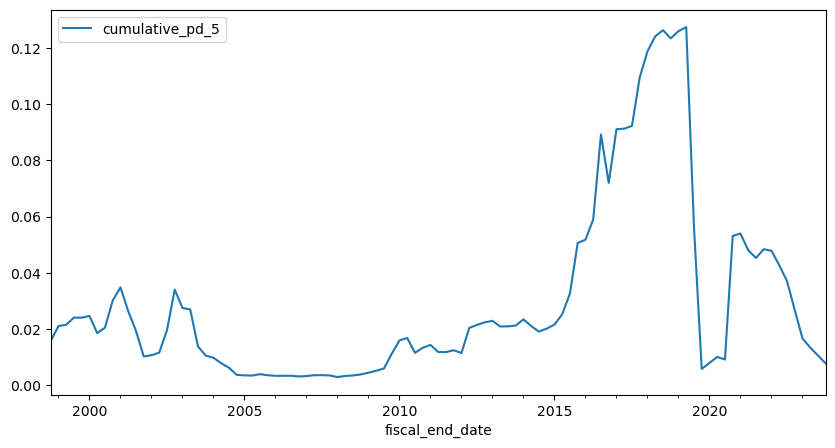

In [215]:
temp = df[df['fsym_id'] == 'K7TZB5-R']
print(temp['cumulative_pd_5'].max())
temp.set_index('fiscal_end_date')[['cumulative_pd_5']].plot(figsize=(10,5))

In [186]:
# find high PD but no default
temp = df.copy()
temp = temp[temp['default_1'] == 1]
defaulted_fsym_list = temp['fsym_id'].unique().tolist()

temp = df[~df['fsym_id'].isin(defaulted_fsym_list)]
temp = temp.sort_values(by='pd_1', ascending=False)
temp[['fsym_id', 'fiscal_end_date', 'ff_assets_in_usd_decile', 'pd_1', 'default_1']]

temp2 = data[['fsym_id', 'name1', 'name2', 'bankruptcy_date']].copy()
temp2 = temp2.drop_duplicates(subset='fsym_id', keep='first')
temp = temp.merge(temp2, how='left', on='fsym_id')

temp = temp.drop_duplicates(subset='fsym_id', keep='first')
temp = temp[temp['pd_1'] > 0.03]

temp[['fsym_id','name1', 'name2', 'fiscal_end_date', 'bankruptcy_date', 'ff_assets_in_usd_decile', 'pd_1', 'default_1']].to_csv('/Users/joeybortfeld/Downloads/high_pd_no_default.csv', index=False)

In [192]:
temp = pd.read_csv('/Users/joeybortfeld/Documents/QML Solutions Data/universe_and_traits/bankruptcy_data.csv')

temp['entity_country_hq'].value_counts()

entity_country_hq
United States         1636
Canada                  38
India                   31
United Kingdom          21
Australia               14
China                   14
Bermuda                 10
Brazil                   9
South Korea              8
Hong Kong                7
Taiwan                   6
Mexico                   6
Spain                    6
Singapore                6
Poland                   5
Germany                  5
Sweden                   4
Israel                   3
Malaysia                 3
Thailand                 3
Indonesia                3
Denmark                  3
Switzerland              3
Italy                    3
Luxembourg               2
Japan                    2
Vietnam                  2
Norway                   2
France                   2
Ireland                  2
Greece                   2
Argentina                2
Chile                    2
Cyprus                   1
Bangladesh               1
Cayman Islands           1
Croatia   

In [250]:
fsym_list = ['DG71WP-R', 'DG885T-R', 'C5CPSB-R']
for fsym in fsym_list:
    df[df['fsym_id'] == fsym].to_csv(f'/Users/joeybortfeld/Downloads/model_output_{model_num}_{fsym}.csv', index=False)


In [ ]:
temp = df_test[df_test['default_1'] != -1]
temp['default_1'].sum()


In [ ]:
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Example dataset
y_true = np.array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1])  # True binary labels
y_pred_probs = np.array([0.05, 0.9, 0.8, 0.4, 0.7, 0.2, 0.3, 0.85, 0.1, 0.95])  # Predicted probabilities

temp = df.copy()
temp = temp[temp['default_1'] != -1]
temp = temp[temp['pd_1'].notnull()]
temp = temp.reset_index(drop=True)

y_true = temp['default_1']
y_pred_probs = temp['pd_1']

# Step 1: Sort by predicted probabilities
sorted_indices = np.argsort(y_pred_probs)[::-1]
sorted_y_true = y_true[sorted_indices]

# Step 2: Calculate cumulative gains
cumulative_gain = np.cumsum(sorted_y_true) / np.sum(sorted_y_true)

# Step 3: Population percentages
population_percentage = np.linspace(0, 1, len(cumulative_gain))

# Step 4: Calculate Area Under Gain Curve (AUGC)
gain_auc = auc(population_percentage, cumulative_gain)

# Step 5: Plot Gain Curve
plt.figure(figsize=(8, 6))
plt.plot(population_percentage, cumulative_gain, label=f'AUGC = {gain_auc:.2f}', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')  # Baseline for random performance
plt.xlabel('Population Percentage')
plt.ylabel('Cumulative Gain')
plt.title('Gain Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Output AUGC
print(f"Area Under Gain Curve (AUGC): {gain_auc:.2f}")


In [ ]:
df_calibration_curve


In [193]:

import ast
temp = '''[("total_equity_to_assets", "pct"), ("net_income_to_sales", "pct"), ("total_debt_to_ebitda", "pct"), ("cash_to_total_debt", "pct"), ("constant", "level")]'''

# parse the string into a list of tuples
x_specs = ast.literal_eval(temp)


In [ ]:
from statsmodels.formula.api import mixedlm
from statsmodels.genmod.families import Binomial

endog = dff['default_1']
exog = dff[['total_equity_to_assets_pct', 'net_income_to_sales_pct', 'total_debt_to_ebitda_pct', 'cash_to_total_debt_pct', 'constant']]
groups = dff['factset_econ_sector'].astype('category').cat.codes

# Fit the model
model = sm.MixedLM(endog, exog, groups=groups, family=Binomial())
result = model.fit()
print(result.summary())

In [ ]:
data = pd.DataFrame({
    'default': [0, 1, 0, 1, 0, 1, 1, 0],
    'x1': [0.5, 1.3, 2.1, 1.2, 0.7, 1.8, 2.2, 1.0],
    'x2': [1.1, 2.3, 1.8, 2.0, 1.5, 2.1, 1.9, 1.3],
    'x3': [0.7, 0.9, 1.5, 1.1, 1.0, 0.8, 1.4, 0.6],
    'x4': [2.0, 1.9, 2.5, 2.3, 1.8, 2.4, 2.2, 1.7],
    'sector': ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D']
})

# Encode 'sector' as a categorical variable
data['sector'] = data['sector'].astype('category')

# Fit the logistic regression model with random effects
# Use GLM or an equivalent
from statsmodels.genmod.families import Binomial

# Prepare the data
endog = data['default']  # Binary response
exog = sm.add_constant(data[['x1', 'x2', 'x3', 'x4']])  # Predictors with constant
groups = data['sector'].cat.codes  # Random effects grouping

# Fit the model
model = sm.MixedLM(endog, exog, groups=groups, family=Binomial())
result = model.fit()

# Summary of results
print(result.summary())

In [ ]:
from statsmodels.formula.api import mixedlm
from statsmodels.genmod.families import Binomial

endog = dff['default_1']
exog = dff[['total_equity_to_assets_pct', 'net_income_to_sales_pct', 'total_debt_to_ebitda_pct', 'cash_to_total_debt_pct', 'constant']]
groups = dff['factset_econ_sector'].astype('category').cat.codes

# Fit the model
model = sm.MixedLM(endog, exog, groups=groups, family=Binomial())
result = model.fit()
print(result.summary())

In [ ]:

def calculate_cumulative_default_probability(data, coeff_dict):

    df = data.copy()

    # calculate the probability of default at each horizon
    for y_var in ['default_1', 'default_2', 'default_3', 'default_4', 'default_5']:

        t = int(y_var[-1])

        df[f'pd_{t}'] = 0
        for var, coeff in coeff_dict[y_var].items():
            df[f'pd_{t}'] += df[var] * coeff

        df[f'pd_{t}'] = np.exp(df[f'pd_{t}']) / (1 + np.exp(df[f'pd_{t}']))

    # calculate the cumulative probability of default at each horizon
    df[f'cumulative_pd_1'] = df[f'pd_1']
    df[f'cumulative_pd_2'] = df['cumulative_pd_1'] + (1 - df['cumulative_pd_1']) * df[f'pd_2']
    df[f'cumulative_pd_3'] = df['cumulative_pd_2'] + (1 - df['cumulative_pd_2']) * df[f'pd_3']
    df[f'cumulative_pd_4'] = df['cumulative_pd_3'] + (1 - df['cumulative_pd_3']) * df[f'pd_4']
    df[f'cumulative_pd_5'] = df['cumulative_pd_4'] + (1 - df['cumulative_pd_4']) * df[f'pd_5']

    return df

df = data.copy()
df = calculate_cumulative_default_probability(df_train, coeff_dict)
temp = df[df['fsym_id'] == 'DG71WP-R'].set_index('fiscal_end_date')[['cumulative_pd_1', 'cumulative_pd_2', 'cumulative_pd_3', 'cumulative_pd_4', 'cumulative_pd_5']]
temp[['cumulative_pd_1', 'cumulative_pd_5']].plot(figsize=(10,5))
temp.tail(10)


In [ ]:
all_stats

# Bayesian Regression

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
N = 2000  # Number of data points
x1 = np.random.normal(0, 3, N) * 10
x2 = np.random.normal(0, 2, N) * 5
x3 = np.random.rand(N) * 6

B1_true = 2.0
B2_true = 3.45
B3_true = -7.221
B0_true = -1.76
sigma_true = 20.0  # Noise standard deviation
y = B0_true + B1_true * x1 + B2_true * x2 + B3_true * x3 + np.random.normal(0, sigma_true, N)

# Combine features
X = np.column_stack((np.ones(N), x1, x2, x3))  # Add intercept column
features = ["Intercept", "x1", "x2", "x3"]

# plot x1,x2,x3 versus y
plt.scatter(x1, y)
plt.scatter(x2, y)
plt.scatter(x3, y)
plt.show()



In [ ]:


# Define prior, likelihood, and posterior
def log_prior(B):
    """Log-prior: Assume independent normal priors for coefficients."""
    return -0.5 * np.sum(B**2 / 100**2)  # N(0, 100^2)

def log_likelihood(B, X, y):
    """Log-likelihood: Gaussian noise."""
    y_hat = X @ B
    residuals = y - y_hat
    return -0.5 * np.sum((residuals / sigma_true) ** 2)

def log_posterior(B, X, y):
    """Log-posterior is the sum of log-prior and log-likelihood."""
    return log_prior(B) + log_likelihood(B, X, y)

# MCMC Metropolis-Hastings
def metropolis_hastings(X, y, n_samples=5000, step_size=0.1):
    """Metropolis-Hastings sampler."""
    n_features = X.shape[1]
    samples = np.zeros((n_samples, n_features))
    current_B = np.zeros(n_features)  # Start at prior mean (0)
    current_log_posterior = log_posterior(current_B, X, y)
    
    for i in range(n_samples):
        # Propose new coefficients
        proposed_B = current_B + np.random.normal(0, step_size, n_features)
        proposed_log_posterior = log_posterior(proposed_B, X, y)
        
        # Compute acceptance probability
        acceptance_prob = np.exp(proposed_log_posterior - current_log_posterior)
        
        # Accept or reject
        if np.random.rand() < acceptance_prob:
            current_B = proposed_B
            current_log_posterior = proposed_log_posterior
        
        samples[i] = current_B
    
    return samples

# Run MCMC
n_samples = 10000
samples = metropolis_hastings(X, y, n_samples=n_samples, step_size=0.5)

# Analyze Results
burn_in = 2000  # Discard initial samples (burn-in)
posterior_samples = samples[burn_in:]
means = np.mean(posterior_samples, axis=0)

print("Posterior Means:")
for feature, mean in zip(features, means):
    print(f"{feature}: {mean:.3f}")

# Plot posterior distributions
fig, axes = plt.subplots(len(features), 1, figsize=(8, 12))
for i, feature in enumerate(features):
    axes[i].hist(posterior_samples[:, i], bins=50, density=True)
    axes[i].set_title(f"Posterior Distribution of {feature}")
    axes[i].axvline(means[i], color="red", linestyle="--", label="Mean")
    axes[i].legend()

plt.tight_layout()
plt.show()
